![Garbage Classification](image.png)



# Garbage Classification with EfficientNetB0

---
## Project Description
> In this project, we aim to develop a sophisticated **garbage classification system** leveraging the **EfficientNetB0** architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.


**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetB0 and transfer learning for automated waste sorting.


---
## Challenges and Scope
**Key Challenge:** A notable challenge encountered is the inherent **class imbalance** within the dataset.






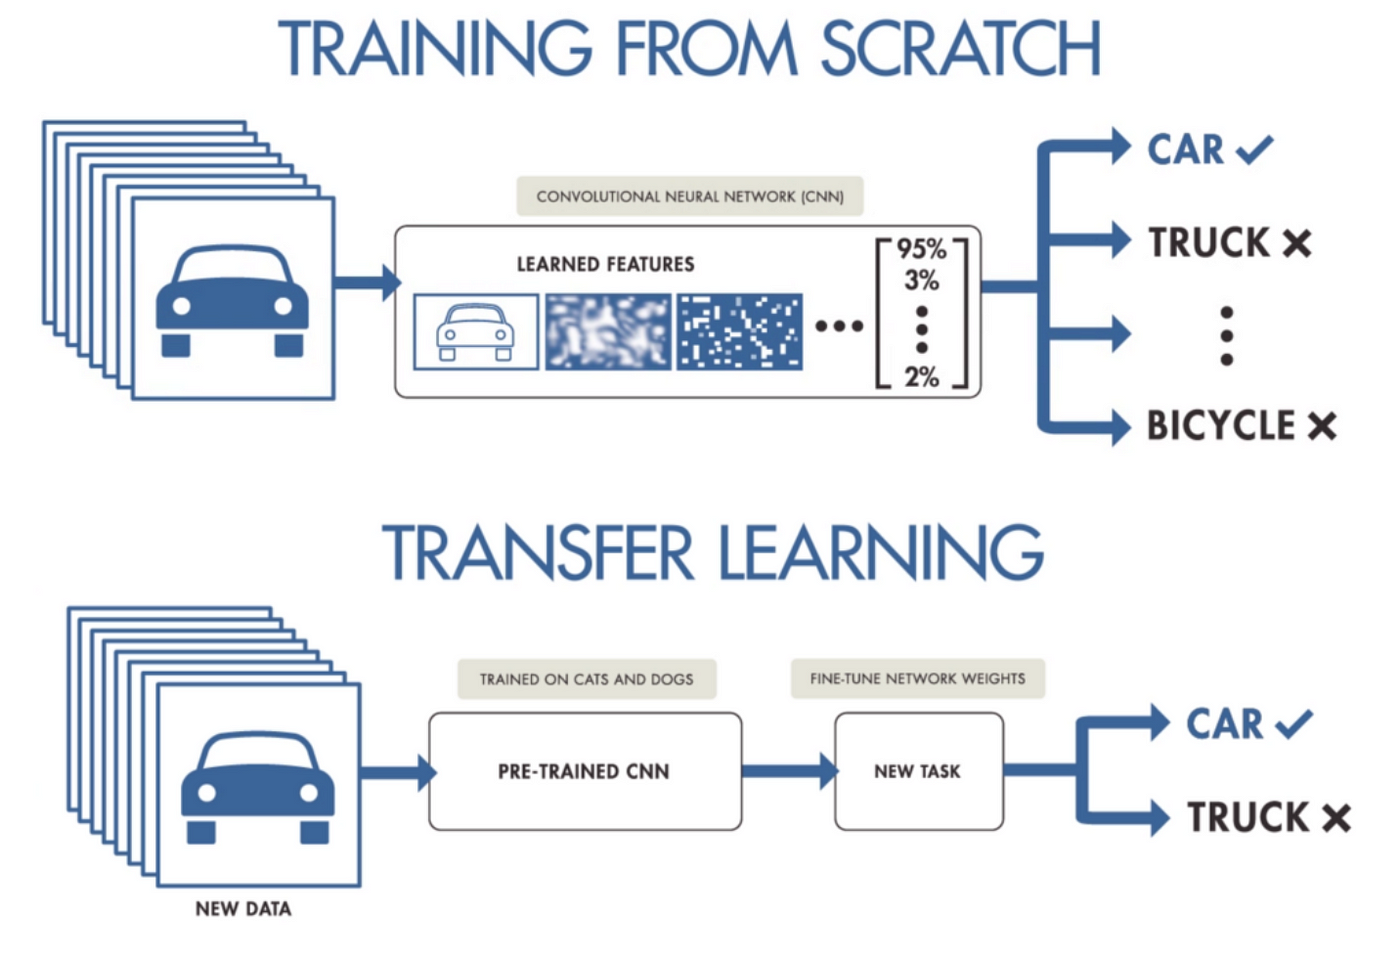


    Transfer Learning is a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task. It also allows us to build accurate models in a time-saving way by starting from patterns learned when solving a different problem. This approach is beneficial when there is limited data for the new task, as the pre-trained model already has learned features that can be adapted. Transfer learning can significantly improve models' performance and efficiency in domains like computer vision and natural language processing.
    
### Benefits
-  **Reduces training time** — you don't start from scratch.
-  **Leverages learned features** from large datasets (like ImageNet).
-  **Improves performance**, especially with limited data.

---

##  How Does It Work?

1.  Load a pretrained model (e.g., ResNet, EfficientNet).
2.  **Freeze** the pretrained layers (optional).
3.  Add new layers for your custom task.
4.  Train on your new dataset (can also fine-tune).
## EfficientNetB0: Transfer Learning Backbone

EfficientNetB0 is a mid-sized model from the EfficientNetV2 family developed by **Google**, balancing performance and efficiency.

### ⚙️ Key Features:
- **Fused MBConv blocks** — enhance both training stability and speed.
- **Progressive learning** — enables better generalization with less computation.
- **Improved architecture** — achieves higher accuracy with optimized FLOPs.

---

## Why Use EfficientNetB0?

| Feature                  | Description                                       |
|--------------------------|---------------------------------------------------|
| Balanced Performance    | Great trade-off between speed and accuracy        |
| Scalable                 | Suitable for moderately complex datasets          |
| Pretrained on ImageNet   | Solid backbone for transfer learning tasks        |
| Efficient                | Faster convergence with fewer resources needed    |

---





###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.

In [1]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetB0 # ImportingEfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

## 1.  Explore and Understand the Data
- Load image dataset using tools like `image_dataset_from_directory`.
- Visualize sample images from each class.
- Check the number of images per class to ensure balance.
- Understand image dimensions, color channels, and class labels.



### Load image dataset using tools like `image_dataset_from_directory`.
### Split data into training, validation, and testing sets.

`tf.keras.utils.image_dataset_from_directory(...)`  
Used to load images from a directory where each subfolder represents a class.

---

**path**  
Root directory path containing one subdirectory per class.

**shuffle=True**  
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

**image_size=(124, 124)**  
Resizes all loaded images to this target size (width, height).  
This must match the input size expected by the model.

**batch_size=32**  
Number of images per batch during training.  
This affects memory usage and the frequency of model updates.

**validation_split=False**  
If set to a float (e.g., `0.2`), splits a portion of the data for validation.  
If `False`, no split is applied.

In [2]:
dataset_dir= r"D:\Project\Garbage Classification\dataset\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2811 files belonging to 6 classes.
Using 2249 files for training.


In [4]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2811 files belonging to 6 classes.
Using 562 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [6]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


### Visualize sample images from each class.

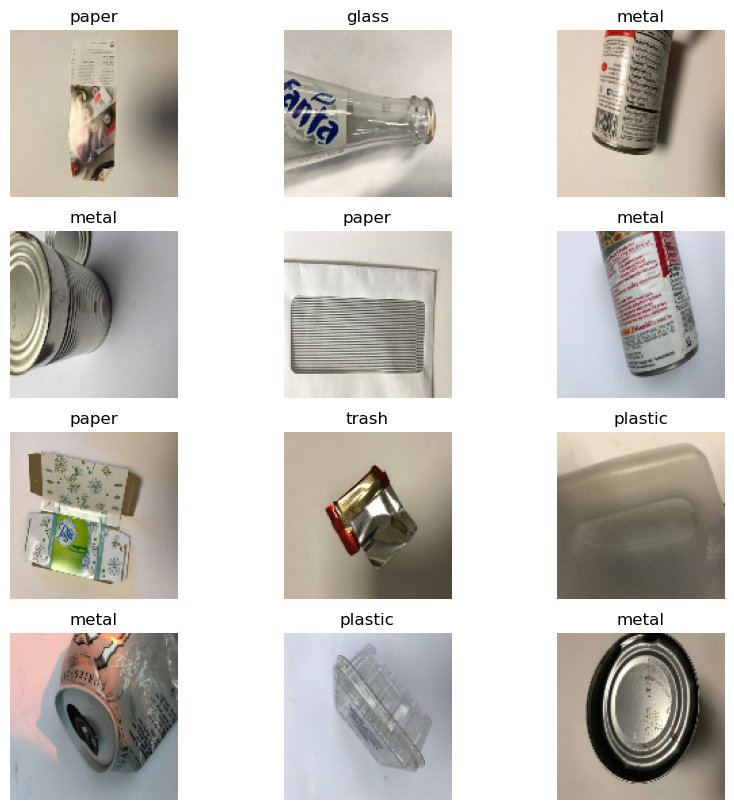

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [10]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 14.81, 'glass': 17.56, 'metal': 13.92, 'paper': 21.16, 'plastic': 18.81, 'trash': 13.74}
{'cardboard': 11.92, 'glass': 18.68, 'metal': 15.48, 'paper': 22.06, 'plastic': 16.9, 'trash': 14.95}
{'cardboard': 13.19, 'glass': 16.67, 'metal': 16.67, 'paper': 22.22, 'plastic': 17.36, 'trash': 13.89}
{'cardboard': 13.37, 'glass': 18.12, 'metal': 14.7, 'paper': 21.61, 'plastic': 17.85, 'trash': 14.34}


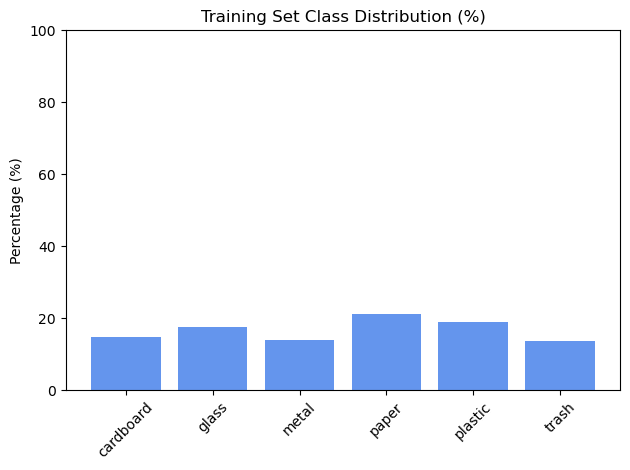

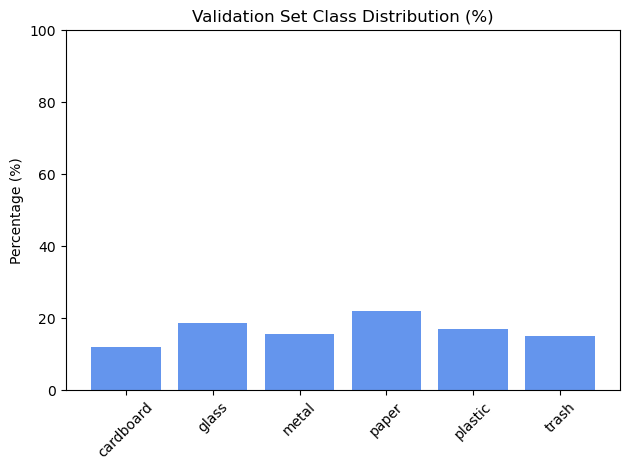

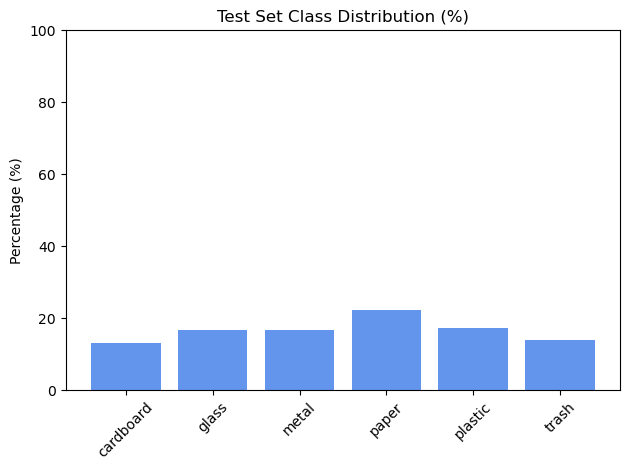

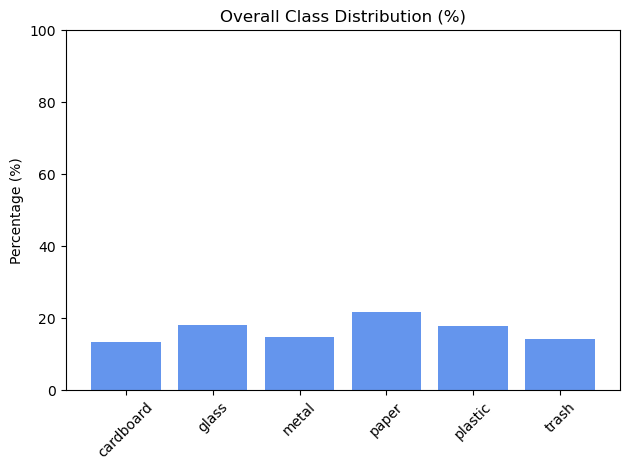

In [11]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")




#  Inference on Class Imbalance

The **"Garbage Image Dataset"** reveals a noticeable **imbalance** in the distribution of its image categories:

| Category     | Image Count | Updated Distribution |
|--------------|-------------|----------------|
| Cardboard | 400          | 15.09           |
|  Glass     | 500         | 19.96           |
|  Metal     | 400         | 16.68           |
|  Paper     | 600         | 23.82          |
|  Plastic   | 500         | 18.53         |
|  Trash     | 393         |  5.91          |

---

### Analogy:
> Imagine teaching a child to identify animals by showing them **95 pictures of cats** and just **5 pictures of dogs**.  
> They'd probably think **most pets are cats**, right?  
> Similarly, our model sees a lot of "**paper**" and very little "**trash**", which **biases** its understanding.

---

###  Key Problems Caused by Class Imbalance:

#### 1️ **Bias**
- The model may **overpredict common classes** like `"paper"` and **underpredict rare ones** like `"trash"`.

#### 2️ **Generalization Issues**
- If the real-world distribution is more balanced, the model may **fail to generalize** and **misclassify rare classes**.

#### 3️ **Accuracy Deception**
- The model might appear to have **high overall accuracy** just by **predicting the majority class**, while **failing** on underrepresented ones.

---

###  Solution Approaches :
- Use **class weights** to handle imbalanced data in training,
- Apply **data augmentation** to increase training data diversity
---

 **Conclusion**: Always check class distribution. A seemingly "accurate" model might just be **biased** toward the dominant class.





### 🛠️ Addressing Imbalance Using Class Weights:

To tackle our imbalanced image dataset, we'll utilize **class weights**. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from **scikit-learn**, based on the distribution of images in each class. The formula is:

$$
\text{weight(class)} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}}
$$

These computed weights are then passed to the model.


In [12]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [13]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 333, 1: 395, 2: 313, 3: 476, 4: 423, 5: 309}
Class Weights: {0: np.float64(1.1256256256256256), 1: np.float64(0.9489451476793249), 2: np.float64(1.1975505857294995), 3: np.float64(0.7874649859943977), 4: np.float64(0.8861308116627266), 5: np.float64(1.2130528586839266)}



## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [14]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetB0`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [15]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(124, 124, 3)
)
#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False




## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`, 
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetB0**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.


In [16]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [17]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 🔁 Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving

In [18]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [36]:
# Set the number of epochs to train the model
epochs = 10  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 584ms/step - accuracy: 0.9687 - loss: 0.1066 - val_accuracy: 0.8790 - val_loss: 0.3692
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.9777 - loss: 0.0875 - val_accuracy: 0.8719 - val_loss: 0.3730
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.9848 - loss: 0.0618 - val_accuracy: 0.8915 - val_loss: 0.3468
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.9854 - loss: 0.0587 - val_accuracy: 0.8932 - val_loss: 0.3440
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 598ms/step - accuracy: 0.9820 - loss: 0.0632 - val_accuracy: 0.8826 - val_loss: 0.3770
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 592ms/step - accuracy: 0.9904 - loss: 0.0411 - val_accuracy: 0.8790 - val_loss: 0.3829
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 559ms/step - accuracy: 0.9931 - loss: 0.0339 - val_accuracy: 0.8879 - val_loss: 0.3402
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.9882 - loss: 0.0463 - val_accu

In [41]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,753,327 (44.84 MB)

 Trainable params: 3,848,034 (14.68 MB)

 Non-trainable params: 209,223 (817.28 KB)

 Optimizer params: 7,696,070 (29.36 MB)

In [42]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 124, 124, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 125, 125, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 62, 62, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 62, 62, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 62, 62, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 3,840,348 (14.65 MB)

 Non-trainable params: 209,223 (817.28 KB)

# Model Performance Visualization: Accuracy & Loss Trends

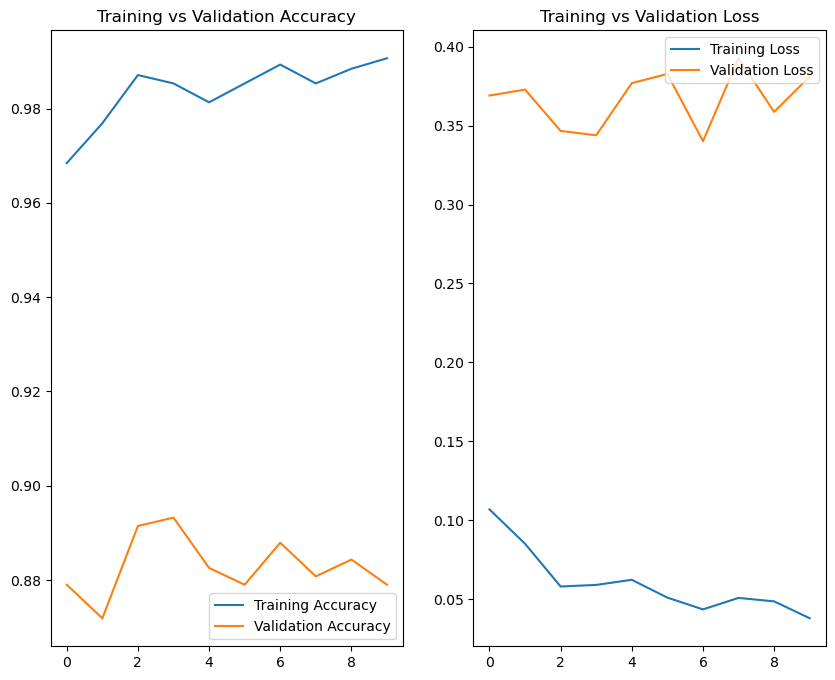

In [43]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

## 5.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.

In [44]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.9252 - loss: 0.1964
Test accuracy is0.8924, Test loss is 0.3107


In [45]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step
[[35  0  0  1  0  0]
 [ 0 47  9  0  0  0]
 [ 1  0 42  0  0  0]
 [ 4  1  0 51  0  2]
 [ 0  2  1  1 46  1]
 [ 0  1  5  2  0 36]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.92      0.84      0.88        56
           2       0.74      0.98      0.84        43
           3       0.93      0.88      0.90        58
           4       1.00      0.90      0.95        51
           5       0.92      0.82      0.87        44

    accuracy                           0.89       288
   macro avg       0.90      0.90      0.89       288
weighted avg       0.90      0.89      0.89       288



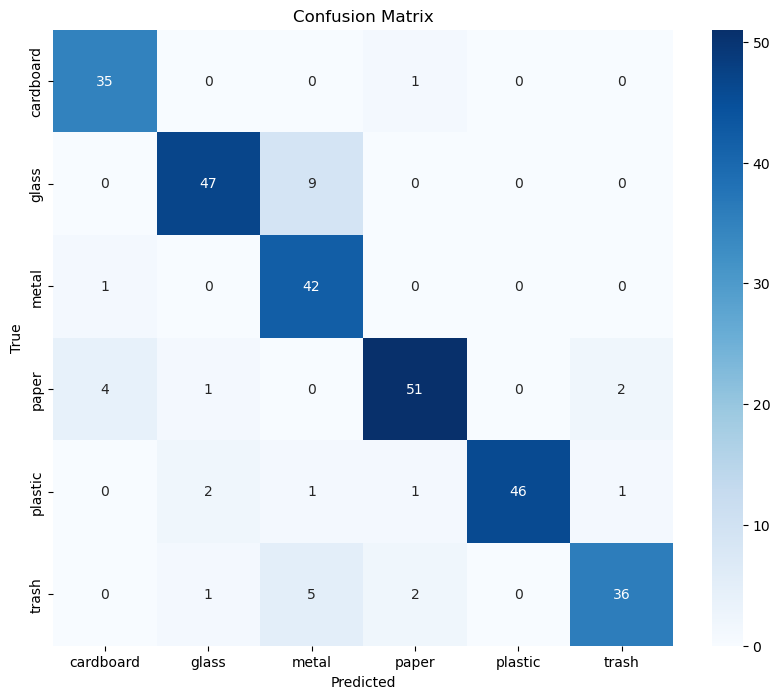

In [46]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

## 7.  Final Testing and Save the Model
- Evaluate the final model on the unseen **test dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


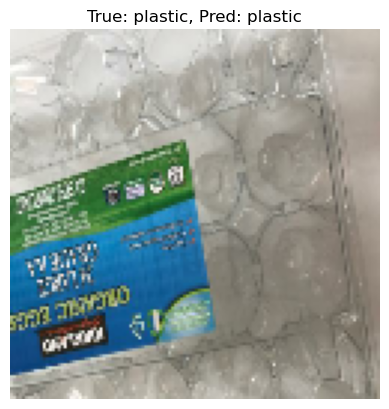

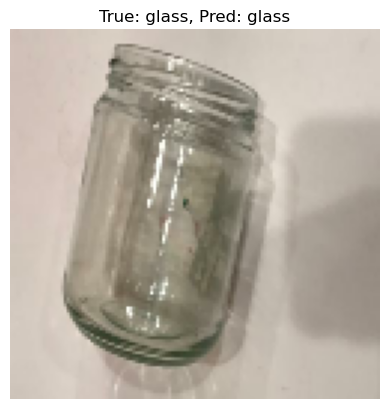

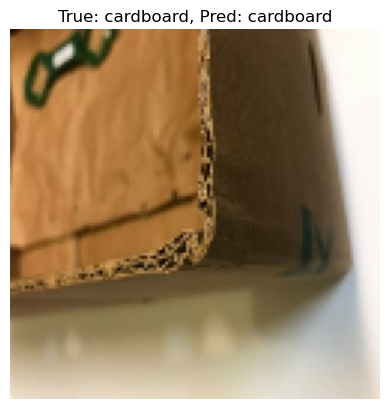

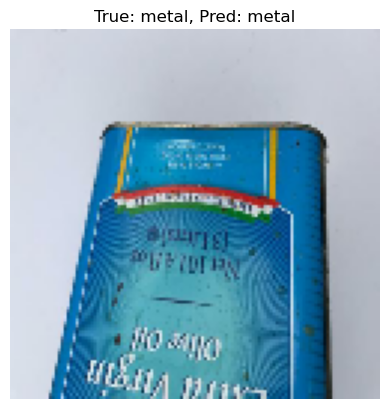

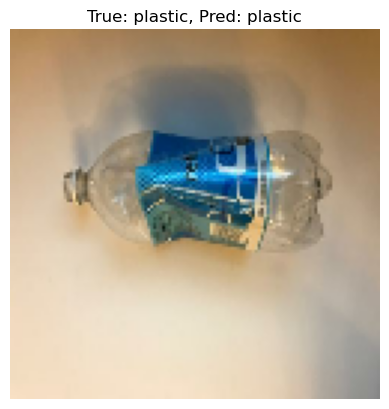

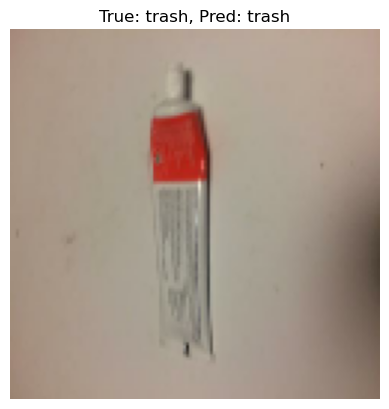

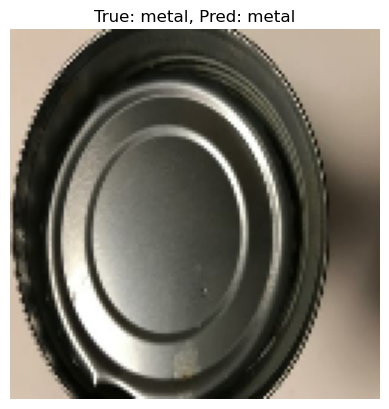

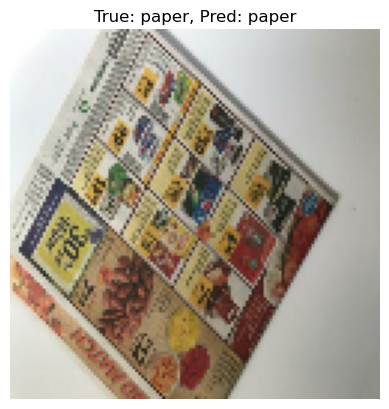

In [47]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [48]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('EfficientNetB0.keras')

# Load your Keras model
model = tf.keras.models.load_model('EfficientNetB0.keras')


## 8.  Model Deployment (Optional)
- Create a web interface using **Gradio**.
- Load the saved model and preprocess input images before prediction.

In [49]:
!pip install gradio

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.


In [2]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
def classify_image(img):  
    # Resize image to 124x124 pixels
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [ ]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction  

## Conclusion

The image classification model demonstrates strong accuracy in identifying objects, leveraging deep learning to refine predictions effectively. Its robust performance ensures reliable classification, making it a valuable tool for various applications.